In [0]:
# import here
import os
import PIL
import pickle
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import torch
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import torch.utils.data.sampler as sampler
from torch import nn, optim
import torch.nn.functional as F
from tqdm import tqdm_notebook as tqdm
%matplotlib inline

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


---
# Load The Data

In [0]:
# Load pickled data
PATH = "./drive/My Drive/critical thinking/"
datasets_path = "./drive/My Drive/critical thinking/data/"
models_path = "./drive/My Drive/critical thinking/models/"

training_file = PATH+ "data/train.pickle"
validation_file = PATH+"data/valid.pickle"
testing_file = PATH+"data/test.pickle"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

# Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (128 by 128) OF THESE IMAGES**

In [0]:
# Number of training examples
n_train = len(X_train)
# Number of validation examples.
n_valid = len(X_valid)
# Number of testing examples.
n_test = len(X_test)

# The shape of an traffic sign image
image_shape = X_train[0].shape[:-1]

# Number of unique classes/labels in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_valid)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 35288
Number of validation examples = 3921
Number of testing examples = 12630
Image data shape = (128, 128)
Number of classes = 43


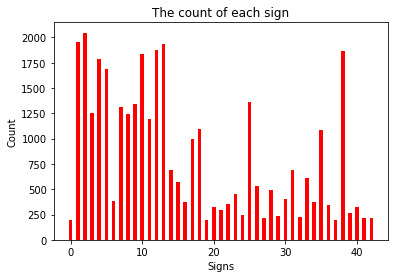

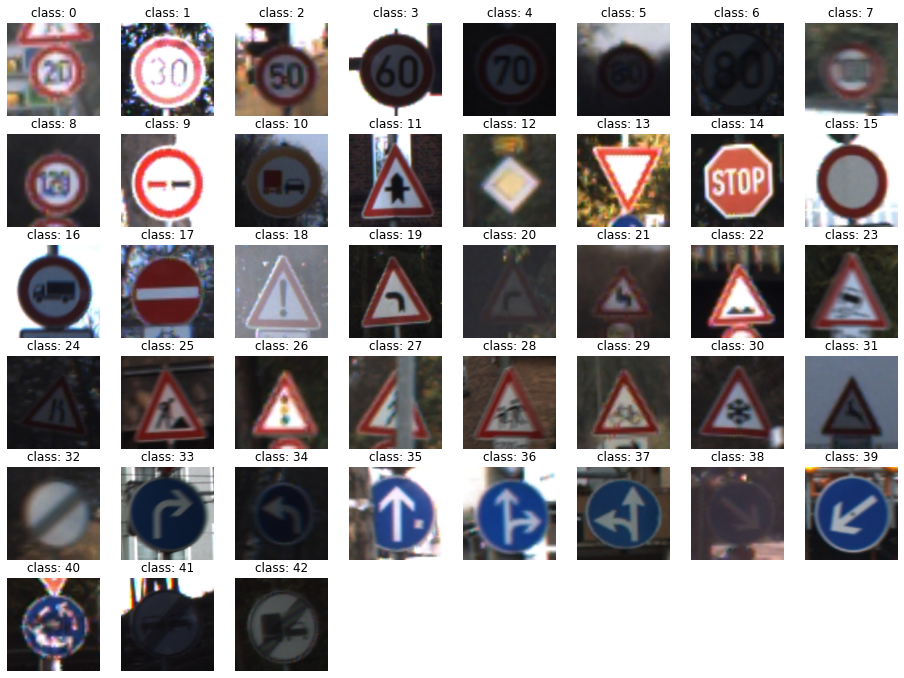

In [0]:
### Data exploration visualization.
fig, ax = plt.subplots()
ax.bar(range(n_classes), np.bincount(y_train), 0.5, color='r')
ax.set_xlabel('Signs')
ax.set_ylabel('Count')
ax.set_title('The count of each sign')
plt.show()

plt.figure(figsize=(16, 16))
for c in range(n_classes):
    i = random.choice(np.where(y_train == c)[0])
    plt.subplot(8, 8, c+1)
    plt.axis('off')
    plt.title('class: {}'.format(c))
    plt.imshow(X_train[i])

----

# Design and Test a Baseline Model Architecture

## Custom Dataset & DataLoader

In [0]:
class PickledDataset(Dataset):
    def __init__(self, file_path, transform=None):
        with open(file_path, mode='rb') as f:
            data = pickle.load(f)
            self.features = data['features']
            self.labels = data['labels']
            self.count = len(self.labels)
            self.transform = transform
        
    def __getitem__(self, index):
        feature = self.features[index]
        if self.transform is not None:
            feature = self.transform(feature)
        return (feature, self.labels[index])

    def __len__(self):
        return self.count

In [0]:
class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

## Baseline Model

In [0]:

class BaselineNet(nn.Module):
    def __init__(self, gray=False):
        super(BaselineNet, self).__init__()
        input_chan = 1 if gray else 3
        self.conv1 = nn.Conv2d(input_chan, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 29* 29, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 43)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        
        x = x.view(-1,16*29*29)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## Training

In [0]:
torch.manual_seed(1)

In [0]:
train_dataset = PickledDataset(training_file, transform=transforms.ToTensor())
valid_dataset = PickledDataset(validation_file, transform=transforms.ToTensor())
test_dataset = PickledDataset(testing_file, transform=transforms.ToTensor())

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def to_device(x, y):
    return x.to(device), y.to(device, dtype=torch.int64)

train_loader = WrappedDataLoader(train_loader, to_device)
valid_loader = WrappedDataLoader(valid_loader, to_device)
test_loader = WrappedDataLoader(test_loader, to_device)

In [0]:
model = BaselineNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
n_epochs = 20

In [0]:
def loss_batch(model, loss_func, x, y, opt=None):
    loss = loss_func(model(x), y)
    
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(x)

In [0]:
def valid_batch(model, loss_func, x, y):
    output = model(x)
    loss = loss_func(output, y)
    pred = torch.argmax(output, dim=1)
    correct = pred == y.view(*pred.shape)
    
    return loss.item(), torch.sum(correct).item(), len(x)

In [0]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in tqdm(range(epochs)):
        # Train model
        model.train()
        losses, nums = zip(*[loss_batch(model, loss_func, x, y, opt) for x, y in train_dl])
        train_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        # Validation model
        model.eval()
        with torch.no_grad():
            losses, corrects, nums = zip(*[valid_batch(model, loss_func, x, y) for x, y in valid_dl])
            valid_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
            valid_accuracy = np.sum(corrects) / np.sum(nums) * 100
            print(f"[Epoch {epoch+1}/{epochs}] "
                  f"Train loss: {train_loss:.6f}\t"
                  f"Validation loss: {valid_loss:.6f}\t",
                  f"Validation accruacy: {valid_accuracy:.3f}%")

In [0]:

def evaluate(model, loss_func, dl):
    model.eval()
    with torch.no_grad():
        losses, corrects, nums = zip(*[valid_batch(model, loss_func, x, y) for x, y in dl])
        test_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        test_accuracy = np.sum(corrects) / np.sum(nums) * 100
        
    print(f"Test loss: {test_loss:.6f}\t"
          f"Test accruacy: {test_accuracy:.3f}%")

In [0]:
fit(n_epochs, model, criterion, optimizer, train_loader, valid_loader)
evaluate(model, criterion, test_loader)

[Epoch 1/20] Train loss: 3.451280	Validation loss: 2.653144	 Validation accruacy: 32.849%
[Epoch 2/20] Train loss: 1.763799	Validation loss: 1.208628	 Validation accruacy: 69.268%
[Epoch 3/20] Train loss: 1.031091	Validation loss: 0.757758	 Validation accruacy: 80.898%
[Epoch 4/20] Train loss: 0.751533	Validation loss: 0.700921	 Validation accruacy: 81.255%
[Epoch 5/20] Train loss: 0.584633	Validation loss: 0.526904	 Validation accruacy: 86.202%
[Epoch 6/20] Train loss: 0.473614	Validation loss: 0.373184	 Validation accruacy: 90.870%
[Epoch 7/20] Train loss: 0.418831	Validation loss: 0.372953	 Validation accruacy: 90.258%
[Epoch 8/20] Train loss: 0.340782	Validation loss: 0.431024	 Validation accruacy: 88.370%
[Epoch 9/20] Train loss: 0.298031	Validation loss: 0.316111	 Validation accruacy: 91.864%
[Epoch 10/20] Train loss: 0.257263	Validation loss: 0.323082	 Validation accruacy: 91.507%
[Epoch 11/20] Train loss: 0.226216	Validation loss: 0.234575	 Validation accruacy: 94.287%
[Epoch 1

In [0]:
# torch.save(model.state_dict(), '128baseline_model.pt')

---
# Experiment and find tuning

## Data preprocessing

In [0]:
# class CLAHE_GRAY:
#     def __init__(self, clipLimit=2.5, tileGridSize=(4, 4)):
#         self.clipLimit = clipLimit
#         self.tileGridSize = tileGridSize

#     def __call__(self, im):
#         img_y = cv2.cvtColor(im, cv2.COLOR_RGB2YCrCb)[:,:,0]
#         clahe = cv2.createCLAHE(clipLimit=self.clipLimit, tileGridSize=self.tileGridSize)
#         img_y = clahe.apply(img_y)
#         img_output = img_y.reshape(img_y.shape + (1,))
#         return img_output

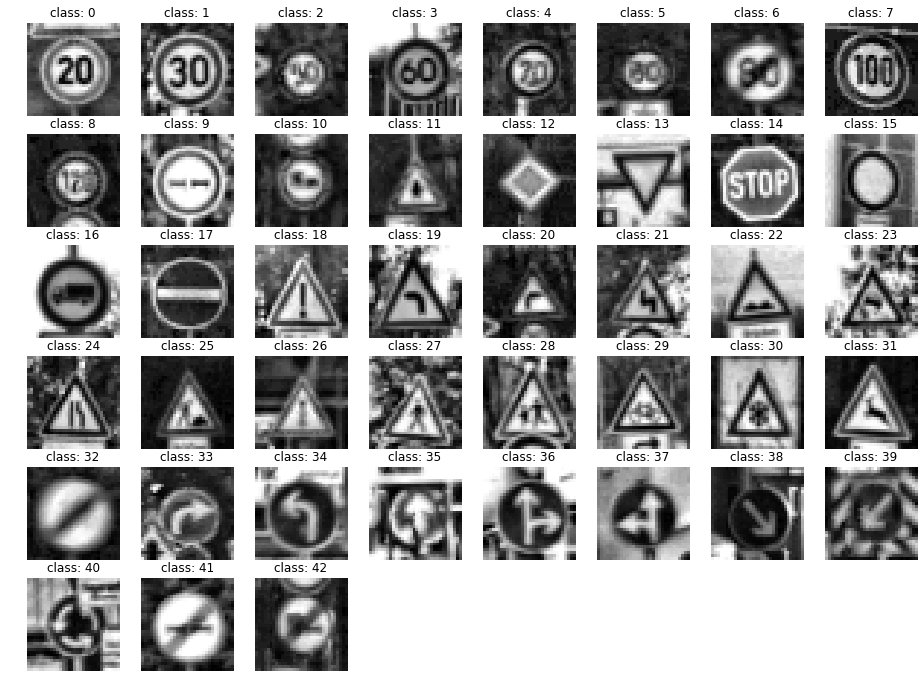

In [0]:
# clahe = CLAHE_GRAY()
# plt.figure(figsize=(16, 16))
# for c in range(n_classes):
#     i = random.choice(np.where(y_train == c)[0])
#     plt.subplot(8, 8, c+1)
#     plt.axis('off')
#     plt.title('class: {}'.format(c))
#     plt.imshow(clahe(X_train[i]).squeeze(), cmap='gray')

In [0]:
data_transforms = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = PickledDataset(training_file, transform=data_transforms)
valid_dataset = PickledDataset(validation_file, transform=data_transforms)
test_dataset = PickledDataset(testing_file, transform=data_transforms)

train_loader = WrappedDataLoader(DataLoader(train_dataset, batch_size=64, shuffle=True), to_device)
valid_loader = WrappedDataLoader(DataLoader(valid_dataset, batch_size=64, shuffle=False), to_device)
test_loader = WrappedDataLoader(DataLoader(test_dataset, batch_size=64, shuffle=False), to_device)

In [0]:
model = BaselineNet(gray=True).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
fit(n_epochs, model, criterion, optimizer, train_loader, valid_loader)
evaluate(model, criterion, test_loader)

[Epoch 1/20] Train loss: 3.727781	Validation loss: 3.685298	 Validation accruacy: 5.442%
[Epoch 2/20] Train loss: 3.526106	Validation loss: 3.555000	 Validation accruacy: 5.442%
[Epoch 3/20] Train loss: 3.442354	Validation loss: 3.492555	 Validation accruacy: 14.512%
[Epoch 4/20] Train loss: 3.124804	Validation loss: 2.771039	 Validation accruacy: 28.277%
[Epoch 5/20] Train loss: 1.981009	Validation loss: 1.633897	 Validation accruacy: 53.991%
[Epoch 6/20] Train loss: 1.198305	Validation loss: 1.081144	 Validation accruacy: 68.957%
[Epoch 7/20] Train loss: 0.837223	Validation loss: 0.817897	 Validation accruacy: 74.875%
[Epoch 8/20] Train loss: 0.647382	Validation loss: 0.705472	 Validation accruacy: 78.662%
[Epoch 9/20] Train loss: 0.531661	Validation loss: 0.637482	 Validation accruacy: 79.524%
[Epoch 10/20] Train loss: 0.443964	Validation loss: 0.586119	 Validation accruacy: 82.313%
[Epoch 11/20] Train loss: 0.383529	Validation loss: 0.496184	 Validation accruacy: 84.921%
[Epoch 12/

## Save preprocessed images

In [0]:
# def preprocess(path):
#     if not os.path.exists(f"{path}/train_gray.p"):
#         for dataset in ['train', 'valid', 'test']:
#             with open(f"{path}/{dataset}.p", mode='rb') as f:
#                 data = pickle.load(f)
#                 X = data['features']
#                 y = data['labels']

#             clahe = CLAHE_GRAY()
#             for i in range(len(X)):
#                 X[i] = clahe(X[i])

#             X = X[:, :, :, 0]
#             with open(f"{path}/{dataset}_gray.p", "wb") as f:
#                 pickle.dump({"features": X.reshape(
#                     X.shape + (1,)), "labels": y}, f)

In [0]:
# preprocess('data')
# training_file = 'data/train_gray.p'
# validation_file = "data/valid_gray.p"
# testing_file = "data/test_gray.p"

In [0]:
train_dataset = PickledDataset(training_file, transform=transforms.ToTensor())
valid_dataset = PickledDataset(validation_file, transform=transforms.ToTensor())
test_dataset = PickledDataset(testing_file, transform=transforms.ToTensor())

train_loader = WrappedDataLoader(DataLoader(train_dataset, batch_size=64, shuffle=True), to_device)
valid_loader = WrappedDataLoader(DataLoader(valid_dataset, batch_size=64, shuffle=False), to_device)
test_loader = WrappedDataLoader(DataLoader(test_dataset, batch_size=64, shuffle=False), to_device)

## Handling imbalanced dataset

### Flipping

In [0]:
def extend_dataset(dataset):
    X = dataset.features
    y = dataset.labels
    num_classes = 43
    
    X_extended = np.empty([0] + list(dataset.features.shape)[1:], dtype=dataset.features.dtype)
    y_extended = np.empty([0], dtype = dataset.labels.dtype)
    
    horizontally_flippable = [11, 12, 13, 15, 17, 18, 22, 26, 30, 35]
    vertically_flippable = [1, 5, 12, 15, 17]
    both_flippable = [32, 40]
    cross_flippable = np.array([
        [19, 20],
        [33, 34],
        [36, 37],
        [38, 39],
        [20, 19],
        [34, 33],
        [37, 36],
        [39, 38]
    ])
    
    for c in range(num_classes):
        X_extended = np.append(X_extended, X[y==c], axis=0)  
        
        if c in horizontally_flippable:
            X_extended = np.append(X_extended, X[y==c][:,:,::-1,:], axis=0)
        if c in vertically_flippable:
            X_extended = np.append(X_extended, X[y==c][:,::-1,:,:], axis=0)
        if c in cross_flippable[:,0]:
            flip_c = cross_flippable[cross_flippable[:,0]==c][0][1]
            X_extended = np.append(X_extended, X[y==flip_c][:,:,::-1,:], axis=0)
        if c in both_flippable:
            X_extended = np.append(X_extended, X[y==c][:,::-1,::-1,:], axis=0)
        
        y_extended = np.append(y_extended, np.full(X_extended.shape[0]-y_extended.shape[0], c, dtype=y_extended.dtype))
    
    dataset.features = X_extended
    dataset.labels = y_extended
    dataset.count = len(y_extended)
    
    return dataset

In [0]:
# train_dataset = extend_dataset(train_dataset)
# train_loader = WrappedDataLoader(DataLoader(train_dataset, batch_size=64, shuffle=True), to_device)

In [0]:
### Data exploration visualization.
fig, ax = plt.subplots()
ax.bar(range(n_classes), np.bincount(train_dataset.labels), 0.5, color='r')
ax.set_xlabel('Signs')
ax.set_ylabel('Count')
ax.set_title('The count of each sign')
plt.show()

plt.figure(figsize=(16, 16))
for c in range(n_classes):
    i = random.choice(np.where(train_dataset.labels == c)[0])
    plt.subplot(8, 8, c+1)
    plt.axis('off')
    plt.title('class: {}'.format(c))
    plt.imshow(train_dataset.features[i].squeeze(), cmap='gray')

In [0]:
model = BaselineNet().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
fit(n_epochs, model, criterion, optimizer, train_loader, valid_loader)
evaluate(model, criterion, test_loader)

[Epoch 1/20] Train loss: 2.619367	Validation loss: 1.460096	 Validation accruacy: 58.378%
[Epoch 2/20] Train loss: 0.986657	Validation loss: 0.808062	 Validation accruacy: 78.883%
[Epoch 3/20] Train loss: 0.589958	Validation loss: 0.675084	 Validation accruacy: 80.209%
[Epoch 4/20] Train loss: 0.407094	Validation loss: 0.374121	 Validation accruacy: 90.589%
[Epoch 5/20] Train loss: 0.301705	Validation loss: 0.362157	 Validation accruacy: 90.028%
[Epoch 6/20] Train loss: 0.227123	Validation loss: 0.269654	 Validation accruacy: 93.140%
[Epoch 7/20] Train loss: 0.179370	Validation loss: 0.210953	 Validation accruacy: 94.644%
[Epoch 8/20] Train loss: 0.145665	Validation loss: 0.213145	 Validation accruacy: 94.593%
[Epoch 9/20] Train loss: 0.121786	Validation loss: 0.172042	 Validation accruacy: 96.174%
[Epoch 10/20] Train loss: 0.098669	Validation loss: 0.165880	 Validation accruacy: 96.225%
[Epoch 11/20] Train loss: 0.080735	Validation loss: 0.145428	 Validation accruacy: 97.016%
[Epoch 1

### Augmentation

In [0]:
train_dataset = extend_dataset(PickledDataset(training_file))

class_sample_count = np.bincount(train_dataset.labels)
weights = 1 / np.array([class_sample_count[y] for y in train_dataset.labels])
samp = sampler.WeightedRandomSampler(weights, 43 * 20000)

#train_loader = WrappedDataLoader(DataLoader(train_dataset, batch_size=64, sampler=samp), to_device)

In [0]:
# balanced_y_train = torch.LongTensor([]).to(device)

# with torch.no_grad():
#     for _, y in train_loader:
#         balanced_y_train = torch.cat((balanced_y_train, y))

# fig, ax = plt.subplots()
# ax.bar(range(n_classes), np.bincount(balanced_y_train.cpu().numpy()), 0.5, color='r')
# ax.set_xlabel('Signs')
# ax.set_ylabel('Count')
# ax.set_title('The count of each sign')
# plt.show()

In [0]:
train_data_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomApply([
        transforms.RandomRotation(20, resample=PIL.Image.BICUBIC),
        transforms.RandomAffine(0, translate=(0.2, 0.2), resample=PIL.Image.BICUBIC),
        transforms.RandomAffine(0, shear=20, resample=PIL.Image.BICUBIC),
        transforms.RandomAffine(0, scale=(0.8, 1.2), resample=PIL.Image.BICUBIC)
    ]),
    transforms.ToTensor()
])
test_data_transforms = transforms.ToTensor()

train_dataset = extend_dataset(PickledDataset(training_file, transform=train_data_transforms))
valid_dataset = PickledDataset(validation_file, transform=test_data_transforms)
test_dataset = PickledDataset(testing_file, transform=test_data_transforms)

train_loader = WrappedDataLoader(DataLoader(train_dataset, batch_size=64, sampler=samp), to_device)
valid_loader = WrappedDataLoader(DataLoader(valid_dataset, batch_size=64, shuffle=False), to_device)
test_loader = WrappedDataLoader(DataLoader(test_dataset, batch_size=64, shuffle=False), to_device)

In [0]:

def convert_image_np(img):
    img = img.numpy().transpose((1, 2, 0)).squeeze()
    return img

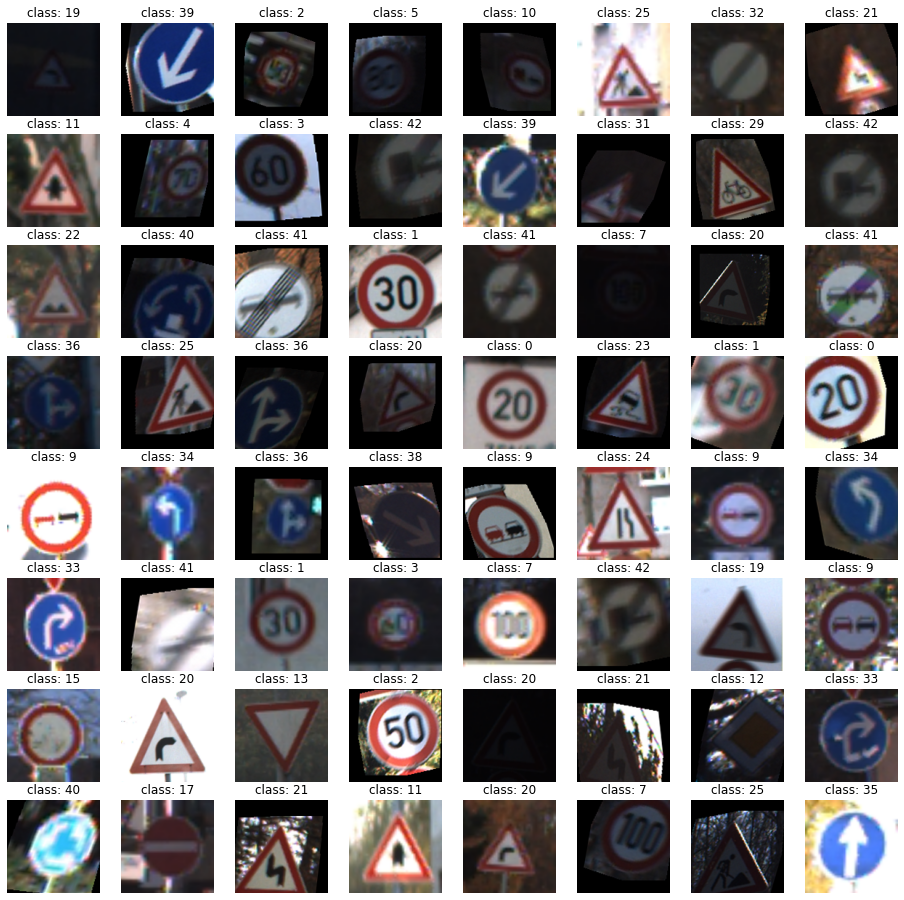

In [0]:
with torch.no_grad():
    x, y = next(iter(train_loader))
    plt.figure(figsize=(16, 16))
    for i in range(len(y)):
        plt.subplot(8, 8, i+1)
        plt.axis('off')
        plt.title('class: {}'.format(y[i]))
        plt.imshow(convert_image_np(x[i].cpu()), cmap='gray')

In [0]:
model = BaselineNet().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
fit(10, model, criterion, optimizer, train_loader, valid_loader)
evaluate(model, criterion, test_loader)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


[Epoch 1/10] Train loss: 1.343982	Validation loss: 0.158981	 Validation accruacy: 95.409%
[Epoch 2/10] Train loss: 0.527160	Validation loss: 0.082893	 Validation accruacy: 97.756%
[Epoch 3/10] Train loss: 0.386736	Validation loss: 0.055407	 Validation accruacy: 98.393%
[Epoch 4/10] Train loss: 0.316087	Validation loss: 0.072384	 Validation accruacy: 97.781%


In [0]:
evaluate(model, criterion, test_loader)

NameError: ignored

In [0]:
torch.save(model.state_dict(), models_path+'128baseline_model2.pt')

## Model

In [0]:
class TrafficSignNet(nn.Module):
    def __init__(self):
        super(TrafficSignNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 100, 5)
        self.conv1_bn = nn.BatchNorm2d(100)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(100, 150, 3)
        self.conv2_bn = nn.BatchNorm2d(150)
        self.conv3 = nn.Conv2d(150, 250, 1)
        self.conv3_bn = nn.BatchNorm2d(250)
        self.fc1 = nn.Linear(250 * 15 * 15, 350)
        self.fc1_bn = nn.BatchNorm1d(350)
        self.fc2 = nn.Linear(350, 43)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.pool(F.elu(self.conv1(x)))
        x = self.dropout(self.conv1_bn(x))
        x = self.pool(F.elu(self.conv2(x)))
        x = self.dropout(self.conv2_bn(x))
        
        x = self.pool(F.elu(self.conv3(x)))
        x = self.dropout(self.conv3_bn(x))
        
        x = x.view(-1, 250 * 15 * 15)
        x = F.elu(self.fc1(x))
        x = self.dropout(self.fc1_bn(x))
        x = self.fc2(x)
        return x

In [0]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl, patience=10):
    wait = 0
    valid_loss_min = np.Inf
    for epoch in range(epochs):
        # Train model
        model.train()
        losses, nums = zip(*[loss_batch(model, loss_func, x, y, opt) for x, y in train_dl])
        train_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        # Validation model
        model.eval()
        with torch.no_grad():
            losses, corrects, nums = zip(*[valid_batch(model, loss_func, x, y) for x, y in valid_dl])
            valid_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
            valid_accuracy = np.sum(corrects) / np.sum(nums) * 100
            print(f"[Epoch {epoch+1}/{epochs}] "
                  f"Train loss: {train_loss:.6f}\t"
                  f"Validation loss: {valid_loss:.6f}\t",
                  f"Validation accruacy: {valid_accuracy:.3f}%")
            # Save model if validation loss has decreased
            if valid_loss <= valid_loss_min:
                print(f"Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}). Saving model...")
                torch.save(model.state_dict(), models_path+'128trafficsign_model.pt')
                valid_loss_min = valid_loss
                wait = 0
            # Early stopping
            else:
                wait += 1
                if wait >= patience:
                    print(f"Terminated Training for Early Stopping at Epoch {epoch+1}")
                    return

In [0]:
n_epochs = 20
model = TrafficSignNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
fit(n_epochs, model, criterion, optimizer, train_loader, valid_loader)

[Epoch 1/20] Train loss: 1.052946	Validation loss: 0.412725	 Validation accruacy: 90.640%
Validation loss decreased (inf --> 0.412725). Saving model...
[Epoch 2/20] Train loss: 0.316087	Validation loss: 0.188316	 Validation accruacy: 96.302%
Validation loss decreased (0.412725 --> 0.188316). Saving model...
[Epoch 3/20] Train loss: 0.186189	Validation loss: 0.116702	 Validation accruacy: 97.807%
Validation loss decreased (0.188316 --> 0.116702). Saving model...
[Epoch 4/20] Train loss: 0.124147	Validation loss: 0.091875	 Validation accruacy: 98.087%
Validation loss decreased (0.116702 --> 0.091875). Saving model...
[Epoch 5/20] Train loss: 0.089989	Validation loss: 0.086818	 Validation accruacy: 97.832%
Validation loss decreased (0.091875 --> 0.086818). Saving model...
[Epoch 6/20] Train loss: 0.071670	Validation loss: 0.069570	 Validation accruacy: 98.266%
Validation loss decreased (0.086818 --> 0.069570). Saving model...
[Epoch 7/20] Train loss: 0.059914	Validation loss: 0.060847	 Va

In [0]:
# check_point = torch.load('model.pt', map_location=device)
# model.load_state_dict(check_point)
evaluate(model, criterion, test_loader)

Test loss: 0.195434	Test accruacy: 94.909%


# Spatial transformer networks

In [0]:
class Stn(nn.Module):
    def __init__(self):
        super(Stn, self).__init__()
        # Spatial transformer localization-network
        self.loc_net = nn.Sequential(
            nn.Conv2d(3, 50, 7),
            nn.MaxPool2d(2, 2),
            nn.ELU(),
            nn.Conv2d(50, 100, 5),
            nn.MaxPool2d(2, 2),
            nn.ELU()
        )
        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(100 * 4 * 4, 100),
            nn.ELU(),
            nn.Linear(100, 3 * 2)
        )
        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))
        
    def forward(self, x):
        xs = self.loc_net(x)
        xs = xs.view(-1, 100 * 4 * 4)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)

        return x

In [0]:
nn.Conv2d(3, 100, 5)(x)

RuntimeError: ignored

In [0]:
class TrafficSignNet(nn.Module):
    def __init__(self):
        super(TrafficSignNet, self).__init__()
        self.stn = Stn()
        self.conv1 = nn.Conv2d(3, 100, 5)
        self.conv1_bn = nn.BatchNorm2d(100)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(100, 150, 3)
        self.conv2_bn = nn.BatchNorm2d(150)
        self.conv3 = nn.Conv2d(150, 250, 1)
        self.conv3_bn = nn.BatchNorm2d(250)
        self.fc1 = nn.Linear(250 * 15 * 15, 350)
        self.fc1_bn = nn.BatchNorm1d(350)
        self.fc2 = nn.Linear(350, 43)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.stn(x)
        
        x = self.pool(F.elu(self.conv1(x)))
        x = self.dropout(self.conv1_bn(x))
        x = self.pool(F.elu(self.conv2(x)))
        x = self.dropout(self.conv2_bn(x))
        x = self.pool(F.elu(self.conv3(x)))
        x = self.dropout(self.conv3_bn(x))
        x = x.view(-1, 250 * 15 * 15)
        x = F.elu(self.fc1(x))
        x = self.dropout(self.fc1_bn(x))
        x = self.fc2(x)
        return x

In [0]:
model = TrafficSignNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
fit(1, model, criterion, optimizer, train_loader, valid_loader)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3289: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


RuntimeError: ignored

In [0]:
for x,y in train_loader:
  print(model(x).shape)
  break

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3289: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


RuntimeError: ignored

In [0]:
check_point = torch.load('model.pt', map_location=device)
model.load_state_dict(check_point)
evaluate(model, criterion, test_loader)

Test loss: 0.027407	Test accruacy: 99.327%


## Visualizing the STN results

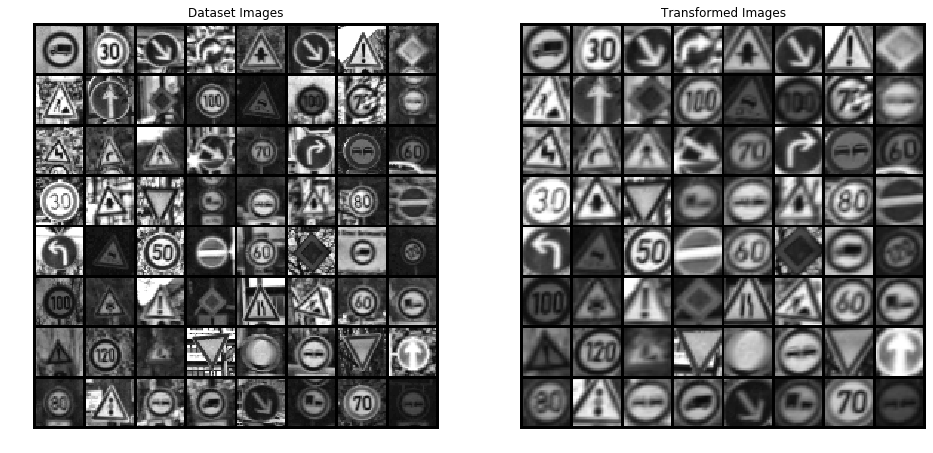

In [0]:
def visualize_stn():
    with torch.no_grad():
        data = next(iter(test_loader))[0].to(device)

        input_tensor = data.cpu()
        transformed_tensor = model.stn(data).cpu()

        input_grid = convert_image_np(make_grid(input_tensor))
        transformed_grid = convert_image_np(make_grid(transformed_tensor))

        # Plot the results side-by-side
        fig, ax = plt.subplots(1, 2)
        fig.set_size_inches((16, 16))
        ax[0].imshow(input_grid)
        ax[0].set_title('Dataset Images')
        ax[0].axis('off')

        ax[1].imshow(transformed_grid)
        ax[1].set_title('Transformed Images')
        ax[1].axis('off')
        
visualize_stn()